In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas_datareader
!pip install yfinance

     |████████████████████████████████| 109 kB 7.5 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 6.4 MB 9.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you hav

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
#import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import tensorflow as tf

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
company = ['AAPL','GOOG','AMZN','XOM','EOG','CVX','CAT','NUE','DHI','DC=F']
start = dt.datetime(1991,1,1)
end = dt.datetime(2021,1,1)
data = []
for c in company :
  df = web.DataReader(c, 'yahoo', start, end)
  data.append(df)


In [ ]:
test_data_scaled = []
train_data_scaled = []
scaler_list = []
for i,df in enumerate(data):
  # separate df with close prices and separate train and test data and scale
  close = df.filter(['Close'])
  train_len = math.ceil(len(close)*0.8)
  train_data = close[0:train_len]
  test_data = close[train_len:]

  # scale the train and test data to avoid leakage into test
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_train = scaler.fit_transform(train_data)
  scaled_test = scaler.transform(test_data)
  
  train_data_scaled.append(np.ravel(scaled_train))
  test_data_scaled.append(np.ravel(scaled_test))

  scaler_list.append(scaler)

In [ ]:

# function for generating the lagged matrix
def split_sequence(sequence, window_size):
    X = []
    y = []

    for i in range(len(sequence)):
        end_idx = i + window_size
        if end_idx > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
X_train_data = []
y_train_data = []
for i,df in enumerate(train_data_scaled):
  X_train, y_train = split_sequence(df, window_size=60)
  X_train_data.append(X_train)
  y_train_data.append(y_train)

X_test_data = []
y_test_data = []
for i,df in enumerate(train_data_scaled):
  X_test, y_test = split_sequence(df, window_size=60)
  X_test_data.append(X_test)
  y_test_data.append(y_test)  

In [ ]:
X_test_data[0].shape
company_names = ['Apple','Google','Amazon','Exxon Mobil Corporation','EOG Resources Inc.','Chevron Corp Caterpillar Inc.','Caterpillar','Nucor Corporation','D R Horton Inc','Gold ']

In [ ]:
from sklearn.svm import SVR
preds = []
for i in range(len(X_train_data)):    
  regressor = SVR(kernel = 'rbf')
  regressor.fit(X_train_data[i], y_train_data[i])
  y_pred = regressor.predict(X_test_data[i])
  preds.append(y_pred)
  #y_pred = scaler_list[i].inverse_transform(y_pred_i)
  print("RMSE of SVM :",mean_squared_error(y_test_data[i],y_pred))

RMSE of SVM : 1.989067097389769
RMSE of SVM : 0.5447508703971424
RMSE of SVM : 4.644976107597553
RMSE of SVM : 0.0022127157383445115
RMSE of SVM : 0.007687570939271559
RMSE of SVM : 0.002047780534732546
RMSE of SVM : 0.21495593354062698
RMSE of SVM : 0.0009074246663010206
RMSE of SVM : 0.2648532429734056
RMSE of SVM : 0.01428375229156996


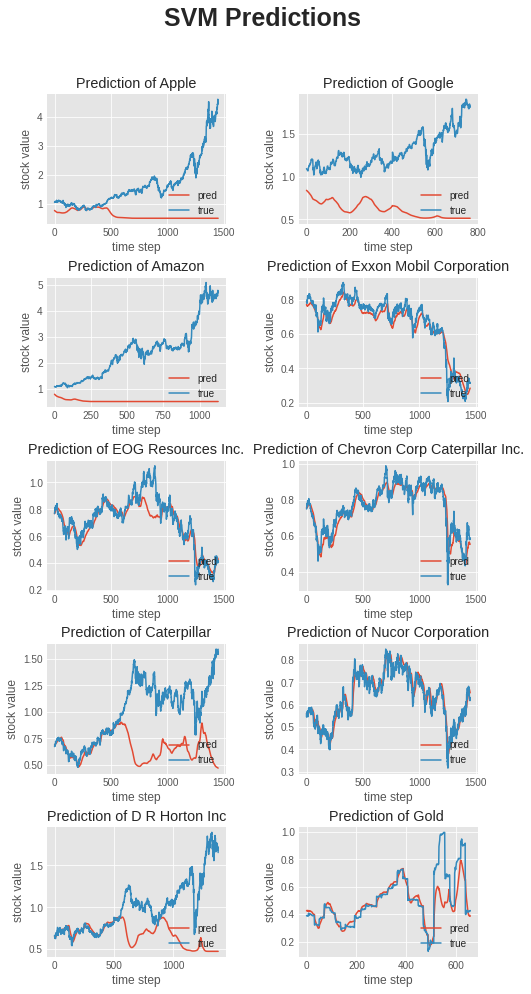

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 10})
plt.title("Predicted values of SVM Model")
plots = []
k=0
for i in range(5):
    for j in range(2):
        ax = plt.subplot2grid((5,2), (i,j))
        ax.plot(preds[k])
        ax.plot(y_test_data[k])
        
        plt.ylabel("stock value")
        plt.xlabel("time step",)
        title_str = "Prediction of " + company_names[k]
        plt.title(title_str)
        ax.legend(["pred", "true"], loc ="lower right")
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.9, wspace=0.4, hspace=0.4)
        k=k+1

plt.suptitle('SVM Predictions\n\n', fontweight ="bold", y=0.98,x=0.3,fontsize=25)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
preds = []
for i in range(len(X_train_data)):
  rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
  rf.fit(X_train_data[i], y_train_data[i])
  y_pred = rf.predict(X_test_data[i])
  preds.append(y_pred)
  print("RMSE of RF :",mean_squared_error(y_test_data[i],y_pred))

RMSE of RF : 1.1976698963251777
RMSE of RF : 0.1466746013764144
RMSE of RF : 3.1632311963486117
RMSE of RF : 0.00016003930931592146
RMSE of RF : 0.0009632982016358186
RMSE of RF : 0.00027695331214373716
RMSE of RF : 0.04559198991869463
RMSE of RF : 0.00019792471857173102
RMSE of RF : 0.07977553494745301
RMSE of RF : 0.0016738134695977174


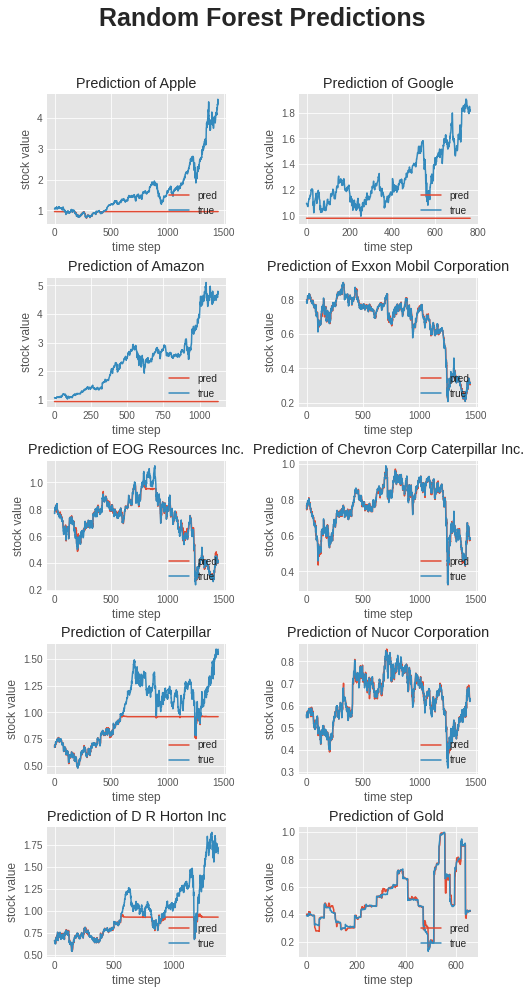

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 10})

plots = []
k=0
for i in range(5):
    for j in range(2):
        ax = plt.subplot2grid((5,2), (i,j))
        ax.plot(preds[k])
        ax.plot(y_test_data[k])
        
        plt.ylabel("stock value")
        plt.xlabel("time step",)
        title_str = "Prediction of " + company_names[k]
        plt.title(title_str)
        ax.legend(["pred", "true"], loc ="lower right")
        plt.subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.9, wspace=0.4, hspace=0.4)
        k=k+1

plt.suptitle('Random Forest Predictions\n\n', fontweight ="bold", y=0.98,x=0.3,fontsize=25)
plt.show()